In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import KFold
from itertools import combinations
from sklearn.metrics import accuracy_score

### Loading Data

In [2]:
train_data1 = np.loadtxt("TP/data/data_tp1_app.txt", delimiter=' ')
test_data1 = np.loadtxt("TP/data/data_tp1_dec.txt", delimiter=' ')

X_train1 = train_data1[:,1:]
y_train1 = train_data1[:,0]

X_test1 = test_data1[:,1:]
y_test1 = test_data1[:,0]

train_data2 = np.loadtxt("TP/data/data_tp2_app.txt", delimiter=' ')
test_data2 = np.loadtxt("TP/data/data_tp2_dec.txt", delimiter=' ')

X_train2 = train_data2[:,1:]
y_train2 = train_data2[:,0]

X_test2 = test_data2[:,1:]
y_test2 = test_data2[:,0]

train_data3 = np.loadtxt("TP/data/data_tp3_app.txt", delimiter=' ')
test_data3 = np.loadtxt("TP/data/data_tp3_dec.txt", delimiter=' ')

X_train3 = train_data3[:,1:]
y_train3 = train_data3[:,0]

X_test3 = test_data3[:,1:]
y_test3 = test_data3[:,0]

## Estimation de Gaussiennes

##### Euclidian and Majalanobis Distances

In [3]:
# Fonction pour calculer la distance euclidienne
def euclidean_distance(point, point2):
    return np.sqrt(np.sum((point - point2) ** 2))

# Fonction pour calculer la distance de Mahalanobis
def mahalanobis_distance(point, centroid, cov_matrix):
    diff = point - centroid
    inv_cov_matrix = np.linalg.inv(cov_matrix)  # Calculer l'inverse de la matrice de covariance
    return np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))

##### Classification

In [4]:
# Classifier les points basés sur la distance euclidienne et retourner les deux classes les plus proches
def classify_by_euclidean(test_data, centroids, unique_classes):
    top1_predictions = []
    top2_predictions = []
    for point in test_data[:, 1:3]:  # Ne considérer que les caractéristiques x1, x2
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        sorted_indices = np.argsort(distances)  # Indices des classes triées par distance croissante
        top1_predictions.append(unique_classes[sorted_indices[0]])  # Première classe (plus proche)
        top2_predictions.append(unique_classes[sorted_indices[1]])  # Deuxième classe (deuxième plus proche)
    return np.array(top1_predictions), np.array(top2_predictions)

# Classifier les points basés sur la distance de Mahalanobis et retourner les deux classes les plus proches
def classify_by_mahalanobis(test_data, centroids, var_cov, unique_classes):
    top1_predictions = []
    top2_predictions = []
    for point in test_data[:, 1:3]:  # Ne considérer que les caractéristiques x1, x2
        distances = [mahalanobis_distance(point, centroids[i], var_cov[i]) for i in range(len(centroids))]
        sorted_indices = np.argsort(distances)  # Indices des classes triées par distance croissante
        top1_predictions.append(unique_classes[sorted_indices[0]])  # Première classe (plus proche)
        top2_predictions.append(unique_classes[sorted_indices[1]])  # Deuxième classe (deuxième plus proche)
    return np.array(top1_predictions), np.array(top2_predictions)

##### Accuaracy and Plotting

In [5]:
# Comparer les prédictions avec les étiquettes réelles pour le Top1 et le Top2
def calculate_accuracy_top2(top1_predictions, top2_predictions, actual_labels):
    correct_top1 = np.sum(top1_predictions == actual_labels)
    correct_top2 = np.sum((top1_predictions == actual_labels) | (top2_predictions == actual_labels))  # Correct si c'est dans les deux premiers
    total = len(actual_labels)
    accuracy_top1 = correct_top1 / total * 100
    accuracy_top2 = correct_top2 / total * 100
    return accuracy_top1, accuracy_top2

# Créer une matrice de confusion
def Matrice_Confusion(actual_labels, predictions):
  classes = set(predictions)
  num_classes = len(classes)
  shape = (num_classes, num_classes)
  mat = np.zeros(shape)
  n = max(len(actual_labels),len(predictions))
  for i in range(num_classes):
    for j in range(num_classes):
      for k in range(n):
        if actual_labels[k]-1 == i:
          if predictions[k]-1 == j:
            mat[i][j] = mat[i][j] + 1
  return mat.astype(int)


# Fonction pour afficher les matrices de confusion côte à côte comme une heatmap
def plot_confusion_matrices(confusion_mtx1, confusion_mtx2, title1, title2, unique_classes):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))  # Création de sous-plots pour afficher les deux heatmaps côte à côte
    
    # Plot de la première matrice de confusion (Euclidienne)
    sns.heatmap(confusion_mtx1, annot=True, fmt='d', cmap='Blues', ax=ax[0], xticklabels=unique_classes, yticklabels=unique_classes)
    ax[0].set_title(title1)
    ax[0].set_xlabel('Classe prédite')
    ax[0].set_ylabel('Classe réelle')
    
    # Plot de la deuxième matrice de confusion (Mahalanobis)
    sns.heatmap(confusion_mtx2, annot=True, fmt='d', cmap='Blues', ax=ax[1], xticklabels=unique_classes, yticklabels=unique_classes)
    ax[1].set_title(title2)
    ax[1].set_xlabel('Classe prédite')
    ax[1].set_ylabel('Classe réelle')
    
    plt.tight_layout()
    plt.show()

# Function to plot classification results side by side (Euclidean and Mahalanobis)
def plot_classifications_side_by_side(test_data, centroids, var_cov, unique_classes, 
                                      euclidean_top1_predictions, mahalanobis_top1_predictions):
    # Define color maps for background and points
    background_colors = ListedColormap(['red', 'orange', 'blue', 'green', 'purple'])
    point_colors = ['red', 'orange', 'blue', 'green', 'purple']

    # Create a mesh grid for decision boundary plotting
    x_min, x_max = test_data[:, 1].min() - 1, test_data[:, 1].max() + 1
    y_min, y_max = test_data[:, 2].min() - 1, test_data[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Set up the figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # ---- Euclidean Plot ----

    # Prédire les classes sur le maillage
    Z_euclidean = np.array([classify_by_euclidean(np.array([[0, x, y]]), centroids, unique_classes)[0][0] 
                            for x, y in zip(xx.ravel(), yy.ravel())]).astype(int)
    Z_euclidean = Z_euclidean.reshape(xx.shape)
    
    # Plot the decision boundary for Euclidean
    ax1.contourf(xx, yy, Z_euclidean, alpha=0.3, cmap=background_colors)
    
    # Plot test points for Euclidean
    for idx, class_label in enumerate(unique_classes):
        class_points = test_data[euclidean_top1_predictions == class_label]
        ax1.scatter(class_points[:, 1], class_points[:, 2], label=f'Cluster {int(class_label)}', 
                    color=point_colors[idx], edgecolor='k')
    
    # Plot centroids for Euclidean
    ax1.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='black', s=100, label='Centroids')
    
    # Set title and labels for the Euclidean plot
    ax1.set_title("Classification using Euclidean Distance")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    

    # ---- Mahalanobis Plot ----
    Z_mahalanobis = np.array([classify_by_mahalanobis(np.array([[0, x, y]]), centroids, var_cov, unique_classes)[0][0] 
                              for x, y in zip(xx.ravel(), yy.ravel())]).astype(int)
    Z_mahalanobis = Z_mahalanobis.reshape(xx.shape)
    
    # Plot the decision boundary for Mahalanobis
    ax2.contourf(xx, yy, Z_mahalanobis, alpha=0.3, cmap=background_colors)
    
    # Plot test points for Mahalanobis
    for idx, class_label in enumerate(unique_classes):
        class_points = test_data[mahalanobis_top1_predictions == class_label]
        ax2.scatter(class_points[:, 1], class_points[:, 2], label=f'Cluster {int(class_label)}', 
                    color=point_colors[idx], edgecolor='k')
    
    # Plot centroids for Mahalanobis
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='black', s=100, label='Centroids')
    
    # Set title and labels for the Mahalanobis plot
    ax2.set_title("Classification using Mahalanobis Distance")
    ax2.set_xlabel("x1")
    ax2.set_ylabel("x2")
    

    # Show the plots side by side
    plt.tight_layout()
    plt.show()

##### Prediction Results

In [6]:
# Fonction pour effectuer la classification et générer les matrices de confusion
def PredictResults(train_data, test_data):
    # Calculer les centroides et matrices de variance-covariance pour chaque classe
    unique_classes = np.unique(train_data[:, 0])
    centroids = np.zeros((len(unique_classes), 2))
    var_cov = np.zeros((len(unique_classes), 2, 2))

    for i, w in enumerate(unique_classes):
        centroids[i] = train_data[train_data[:, 0] == w, 1:3].mean(axis=0)
        var_cov[i] = np.cov(train_data[train_data[:, 0] == w, 1:3], rowvar=False)

    # Prédire les classes avec les deux méthodes
    euclidean_top1_predictions, euclidean_top2_predictions = classify_by_euclidean(test_data, centroids, unique_classes)
    mahalanobis_top1_predictions, mahalanobis_top2_predictions = classify_by_mahalanobis(test_data, centroids, var_cov, unique_classes)

    # Étiquettes réelles (colonne 0 de test_data)
    actual_labels = test_data[:, 0]

    # Calculer la précision pour chaque méthode
    euclidean_accuracy_top1, euclidean_accuracy_top2 = calculate_accuracy_top2(euclidean_top1_predictions, euclidean_top2_predictions, actual_labels)
    mahalanobis_accuracy_top1, mahalanobis_accuracy_top2 = calculate_accuracy_top2(mahalanobis_top1_predictions, mahalanobis_top2_predictions, actual_labels)

    # Générer les matrices de confusion
    confusion_matrix_euclidean = Matrice_Confusion(actual_labels, euclidean_top1_predictions)
    confusion_matrix_mahalanobis = Matrice_Confusion(actual_labels, mahalanobis_top1_predictions)

    # Afficher les résultats
    print(f"Précision Euclidienne Top1 : {euclidean_accuracy_top1:.2f}%")
    print(f"Précision Euclidienne Top2 : {euclidean_accuracy_top2:.2f}%")
    print(f"\nPrécision Mahalanobis Top1 : {mahalanobis_accuracy_top1:.2f}%")
    print(f"Précision Mahalanobis Top2 : {mahalanobis_accuracy_top2:.2f}%")

    # Afficher les matrices de confusion côte à côte
    plot_confusion_matrices(confusion_matrix_euclidean, confusion_matrix_mahalanobis, 
                            "Matrice de confusion (Euclidienne)", "Matrice de confusion (Mahalanobis)", unique_classes)

    
    # Plot classification results side by side
    plot_classifications_side_by_side(test_data, centroids, var_cov, unique_classes, 
                                      euclidean_top1_predictions, mahalanobis_top1_predictions)

In [7]:
# PredictResults(train_data1, test_data1)
# PredictResults(train_data2, test_data2)
# PredictResults(train_data3, test_data3)

## Kppv

##### Classification

In [8]:
def predict_kppv(X_train, X_test, y_train, k):
    final_output = []
    for i in range(len(X_test)):
        d = []
        votes = []
        for j in range(len(X_train)):
            dist = euclidean_distance(X_train[j] , X_test[i])
            d.append([dist, j])
        d.sort()
        d = d[0:k]
        for d, j in d:
            votes.append(y_train[j])
            ans = Counter(votes).most_common(1)[0][0]
        final_output.append(ans)

    return final_output

def calculate_accuracy_kppv(prediction, y_test):
    return (prediction == y_test).sum()* 100 / len(y_test)


##### Plotting

In [9]:
def plot_confusion_matrices(confusion_mtx1, confusion_mtx2, confusion_mtx3, title1, title2, title3, unique_classes):
    # Criar a figura com 3 subgráficos: dois na linha superior e um na inferior
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Ajustar o espaço entre os gráficos

    # Plot da primeira matriz de confusão
    sns.heatmap(confusion_mtx1, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=unique_classes, yticklabels=unique_classes)
    ax1.set_title(title1)
    ax1.set_xlabel('Classe Predita')
    ax1.set_ylabel('Classe Real')

    # Plot da segunda matriz de confusão
    sns.heatmap(confusion_mtx2, annot=True, fmt='d', cmap='Blues', ax=ax2, xticklabels=unique_classes, yticklabels=unique_classes)
    ax2.set_title(title2)
    ax2.set_xlabel('Classe Predita')
    ax2.set_ylabel('Classe Real')

    # Plot da terceira matriz de confusão
    unique_classes = np.append(unique_classes,6)
    sns.heatmap(confusion_mtx3, annot=True, fmt='d', cmap='Blues', ax=ax3, xticklabels=unique_classes, yticklabels=unique_classes)
    ax3.set_title(title3)
    ax3.set_xlabel('Classe Predita')
    ax3.set_ylabel('Classe Real')

    # Mostrar os gráficos
    plt.tight_layout()
    plt.show()


def plot_kppv_side_by_side(X_test, unique_classes, prediction1, prediction5, predictionUna):
    
    # Definir as cores dos pontos
    point_colors = ['red', 'orange', 'blue', 'green', 'purple', 'gray']

    # Criar a figura com 3 subgráficos: dois na linha superior e um na inferior
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Ajustar o espaço entre os gráficos
    
    # Gráfico 1: Classificação usando Kppv (1ppv)
    for i in unique_classes:
        ax1.scatter(X_test[prediction1 == i, 0], X_test[prediction1 == i, 1], c=point_colors[int(i) - 1])
    ax1.set_title("Classification using Kppv (1ppv)")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    
    # Gráfico 2: Classificação usando Kppv (5ppv)
    for i in unique_classes:
        ax2.scatter(X_test[prediction5 == i, 0], X_test[prediction5 == i, 1], c=point_colors[int(i) - 1])
    ax2.set_title("Classification using Kppv (1ppv Majorité)")
    ax2.set_xlabel("x1")
    ax2.set_ylabel("x2")
    
    # Gráfico 3: Classificação usando Kppv (3ppv)
    unique_classes = np.append(unique_classes,6)
    for i in unique_classes:
        ax3.scatter(X_test[predictionUna == i, 0], X_test[predictionUna == i, 1], c=point_colors[int(i) - 1])
    ax3.set_title("Classification using Kppv (1ppv Unanimité)")
    ax3.set_xlabel("x1")
    ax3.set_ylabel("x2")
    
    # Mostrar os gráficos
    plt.tight_layout()
    plt.show()


##### Prediction Results

In [10]:
def PredictResults_Kppv(X_train, y_train, X_test, y_test, train_data):

    unique_classes = np.unique(y_train)
    k = 1
    actual_labels = y_train

    # Get the fold indices
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds com randomização
    fold_predictions = []  # Para armazenar as previsões de cada fold

    for train_index, test_index in kf.split(X_train):
        X_trainCV, X_testCV = X_train[train_index], X_train[test_index]
        y_trainCV, y_testCV = y_train[train_index], y_train[test_index]
        
        # Previsões do modelo k-NN para este fold
        y_pred = predict_kppv(X_trainCV, X_test, y_trainCV, k)
        
        # Armazena as previsões
        fold_predictions.append(y_pred)
    
    # Consolidando previsões com o voto da maioria
    prediction1 = predict_kppv(X_train, X_test, y_train, k)
    predictionMaj = np.zeros(len(X_test), dtype=int)
    predictionUna = np.full(len(X_test), 6, dtype=int)
    # vote_counter = {i: [] for i in range(len(y_train))}  # Armazena votos por índice global
    top2_correct = 0  # Contador para o Top2
    
    for i in range(len(X_test)):
        # Coletando previsões para o ponto i em todos os folds
        votes = [fold_predictions[fold][i] for fold in range(len(fold_predictions))]
        
        # Voto da maioria
        vote_count = Counter(votes).most_common()
        predictionMaj[i] = vote_count[0][0]  # Top1
        # predictionMaj[i] = Counter(votes).most_common(1)[0][0]
        
        # Verificação do Top2
        top2_labels = [x[0] for x in vote_count[:2]]  # Dois rótulos mais votados
        if y_test[i] in top2_labels:
            top2_correct += 1  # Incrementa o contador se o rótulo real estiver no Top2
        
        # Unanimidade
        if len(set(votes)) == 1:  # Todos os votos são iguais
            predictionUna[i] = votes[0]    


    # Calculer la précision pour chaque méthode
    accuaracy1 = calculate_accuracy_kppv(prediction1, y_test)
    accuaracyMaj = calculate_accuracy_kppv(predictionMaj, y_test)
    accuaracyUna = calculate_accuracy_kppv(predictionUna, y_test)
    accuracy_top2 = 100*top2_correct / len(X_test)  # Percentual de acertos no Top2

    # Générer les matrices de confusion
    confusion_matrix1 = Matrice_Confusion(actual_labels, prediction1)
    confusion_matrixMaj = Matrice_Confusion(actual_labels, predictionMaj)
    confusion_matrixUna = Matrice_Confusion(actual_labels, predictionUna)

    # Afficher les résultats
    print(f"Précision classifieur 1ppv : {accuaracy1:.2f}%")
    print(f"Précision classifieur Majorité Top1 : {accuaracyMaj:.2f}%")
    print(f"Précision classifieur Majorité Top2 : {accuracy_top2:.2f}%")
    print(f"Précision classifieur Unanimité : {accuaracyUna:.2f}%")

    # Afficher les matrices de confusion côte à côte
    plot_confusion_matrices(confusion_matrix1, confusion_matrixMaj, confusion_matrixUna,
                            "Matrice de confusion (1ppv)", "Matrice de confusion (5ppv Majorité)", "Matrice de confusion (5ppv Unanimité)", unique_classes)

    # Plot classification results side by side
    plot_kppv_side_by_side(X_test, unique_classes, prediction1, predictionMaj, predictionUna)

Précision classifieur 1ppv : 99.20%
Précision classifieur Majorité Top1 : 99.20%
Précision classifieur Majorité Top2 : 99.60%
Précision classifieur Unanimité : 98.80%


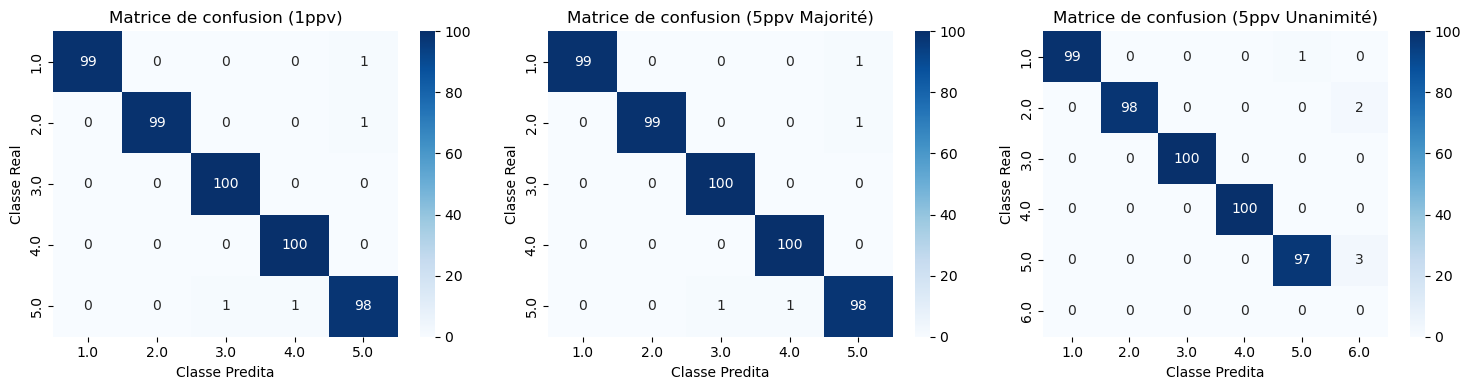

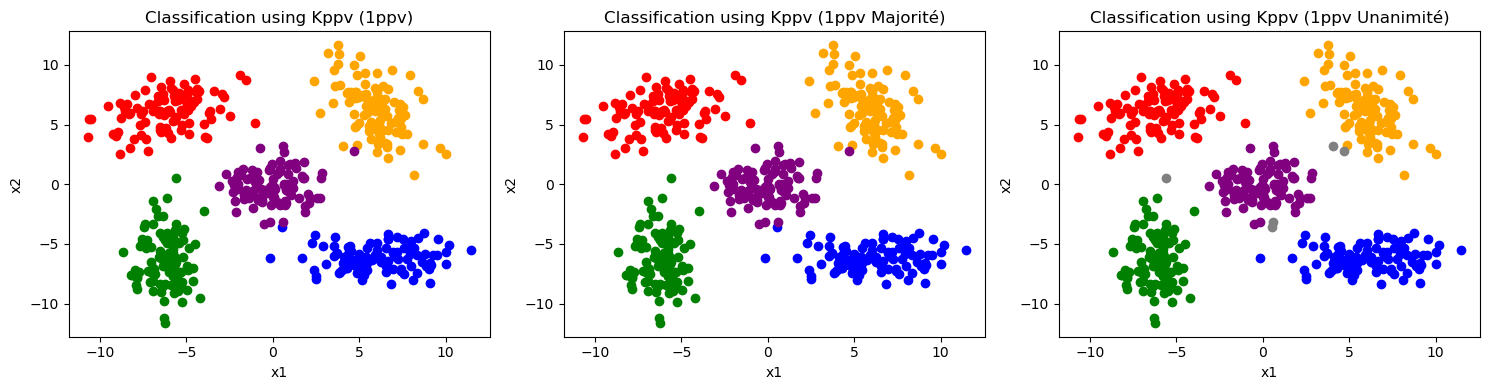

In [11]:
PredictResults_Kppv(X_train1, y_train1, X_test1, y_test1, train_data1)
# PredictResults_Kppv(X_train2, y_train2, X_test2, y_test2, train_data2)
# PredictResults_Kppv(X_train3, y_train3, X_test3, y_test3, train_data3)

## Parzen

##### Classification

In [12]:
def uniform_kernel(distance, bandwidth):
    return 1 if distance <= bandwidth else 0

def gaussian_kernel(distance, bandwidth):
    return np.exp(-0.5 * (distance / bandwidth) ** 2)

def predict_parzen(X_train, X_test, y_train, kernel='uniform', bandwidth=1.0):
    """
    Classificador Parzen baseado em janelas, suportando kernel uniforme e gaussiano.
    
    Parâmetros:
    - X_train: numpy array, conjunto de treinamento.
    - X_test: numpy array, conjunto de teste.
    - y_train: numpy array, rótulos do conjunto de treinamento.
    - kernel: str, tipo de kernel ('uniform' ou 'gaussian').
    - bandwidth: float, largura de banda (raio ou sigma para o kernel).
    
    Retorna:
    - y_pred: numpy array, rótulos previstos para X_test.
    """
    if kernel == 'uniform':
        kernel_func = uniform_kernel
    elif kernel == 'gaussian':
        kernel_func = gaussian_kernel
    else:
        raise ValueError("Kernel deve ser 'uniform' ou 'gaussian'.")

    y_pred = []
    for x_test in X_test:
        # Calcula as distâncias entre x_test e todos os pontos de X_train
        distances = np.linalg.norm(X_train - x_test, axis=1)
        
        # Calcula as contribuições (pesos) de cada ponto no conjunto de treinamento
        weights = np.array([kernel_func(d, bandwidth) for d in distances])
        
        # Multiplica os pesos pelos rótulos
        label_weights = {}
        for label, weight in zip(y_train, weights):
            label_weights[label] = label_weights.get(label, 0) + weight
        
        # Classifica pela soma de pesos
        if label_weights:
            predicted_label = max(label_weights, key=label_weights.get)
        else:
            predicted_label = None  # Pode retornar um padrão ou tratar o caso separadamente
        
        y_pred.append(predicted_label)
    
    return np.array(y_pred)

In [13]:
def plot_Parzen_side_by_side(X_test, unique_classes, prediction1, prediction2, prediction3, prediction4):
    
    # Definir as cores dos pontos
    point_colors = ['red', 'orange', 'blue', 'green', 'purple', 'gray']

    # Criar a figura com 3 subgráficos: dois na linha superior e um na inferior
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Ajustar o espaço entre os gráficos
    
    # Gráfico 1: Classificação usando Kppv (1ppv)
    for i in unique_classes:
        ax1.scatter(X_test[prediction1 == i, 0], X_test[prediction1 == i, 1], c=point_colors[int(i) - 1])
    ax1.set_title("Classification using Kppv (1ppv)")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    
    # Gráfico 2: Classificação usando Kppv (5ppv)
    for i in unique_classes:
        ax2.scatter(X_test[prediction2 == i, 0], X_test[prediction2 == i, 1], c=point_colors[int(i) - 1])
    ax2.set_title("Classification using Kppv (1ppv Majorité)")
    ax2.set_xlabel("x1")
    ax2.set_ylabel("x2")
    
    # Gráfico 2: Classificação usando Kppv (5ppv)
    for i in unique_classes:
        ax3.scatter(X_test[prediction3 == i, 0], X_test[prediction3 == i, 1], c=point_colors[int(i) - 1])
    ax3.set_title("Classification using Kppv (1ppv Majorité)")
    ax3.set_xlabel("x1")
    ax3.set_ylabel("x2")
    
    # Gráfico 2: Classificação usando Kppv (5ppv)
    for i in unique_classes:
        ax4.scatter(X_test[prediction4 == i, 0], X_test[prediction4 == i, 1], c=point_colors[int(i) - 1])
    ax4.set_title("Classification using Kppv (1ppv Majorité)")
    ax4.set_xlabel("x1")
    ax4.set_ylabel("x2")
    
    # Mostrar os gráficos
    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrices_Parzen(confusion_mtx1, confusion_mtx2, confusion_mtx3, confusion_mtx4, title1, title2, title3, title4, unique_classes):
    # Criar a figura com 3 subgráficos: dois na linha superior e um na inferior
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Ajustar o espaço entre os gráficos

    # Plot da primeira matriz de confusão
    sns.heatmap(confusion_mtx1, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=unique_classes, yticklabels=unique_classes)
    ax1.set_title(title1)
    ax1.set_xlabel('Classe Predita')
    ax1.set_ylabel('Classe Real')

    # Plot da segunda matriz de confusão
    sns.heatmap(confusion_mtx2, annot=True, fmt='d', cmap='Blues', ax=ax2, xticklabels=unique_classes, yticklabels=unique_classes)
    ax2.set_title(title2)
    ax2.set_xlabel('Classe Predita')
    ax2.set_ylabel('Classe Real')

    # Plot da terceira matriz de confusão
    sns.heatmap(confusion_mtx3, annot=True, fmt='d', cmap='Blues', ax=ax3, xticklabels=unique_classes, yticklabels=unique_classes)
    ax3.set_title(title3)
    ax3.set_xlabel('Classe Predita')
    ax3.set_ylabel('Classe Real')
    
        # Plot da terceira matriz de confusão
    sns.heatmap(confusion_mtx4, annot=True, fmt='d', cmap='Blues', ax=ax4, xticklabels=unique_classes, yticklabels=unique_classes)
    ax4.set_title(title4)
    ax4.set_xlabel('Classe Predita')
    ax4.set_ylabel('Classe Real')

    # Mostrar os gráficos
    plt.tight_layout()
    plt.show()


In [14]:
def find_best_bandwidth_parzen(X_train, y_train, h_values, n_splits=5, kernel='uniform'):
    """
    Encontra o melhor bandwidth (h) usando validação cruzada nos dados de treinamento.
    
    Parâmetros:
    - X_train, y_train: dados de treinamento.
    - h_values: lista de valores de h (bandwidth) para testar.
    - n_splits: número de folds para validação cruzada (default: 5).
    - kernel: tipo de kernel ('uniform' ou 'gaussian').
    
    Retorna:
    - Melhor valor de h com base na precisão Top1 média.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_h = None
    best_accuracy = 0

    for h in h_values:
        fold_accuracies = []

        for train_index, val_index in kf.split(X_train):
            # Divide os dados em treino/validação
            X_trainCV, X_val = X_train[train_index], X_train[val_index]
            y_trainCV, y_val = y_train[train_index], y_train[val_index]

            # Previsões nos dados de validação
            y_pred_val = predict_parzen(X_trainCV, X_val, y_trainCV, kernel=kernel, bandwidth=h)

            # Calcula a precisão Top1 para o fold atual
            fold_accuracy = calculate_accuracy_kppv(y_pred_val, y_val)
            fold_accuracies.append(fold_accuracy)

        # Calcula a precisão média para o valor atual de h
        mean_accuracy = np.mean(fold_accuracies)

        # Atualiza o melhor h
        if mean_accuracy > best_accuracy:
            best_h = h
            best_accuracy = mean_accuracy

    return best_h


def calculate_top2_accuracy(X_train, y_train, X_test, y_test, kernel, bandwidth):
    unique_classes = np.unique(y_train)
    correct_top2 = 0

    for i, x_test in enumerate(X_test):
        distances = np.linalg.norm(X_train - x_test, axis=1)
        if kernel == 'uniform':
            weights = np.array([uniform_kernel(d, bandwidth) for d in distances])
        elif kernel == 'gaussian':
            weights = np.array([gaussian_kernel(d, bandwidth) for d in distances])
        
        label_weights = {label: 0 for label in unique_classes}
        for label, weight in zip(y_train, weights):
            label_weights[label] += weight
        
        top2_labels = [label for label, _ in Counter(label_weights).most_common(2)]
        if y_test[i] in top2_labels:
            correct_top2 += 1

    return correct_top2 / len(X_test) * 100


In [15]:
def PredictResults_Parzen(X_train, y_train, X_test, y_test, bandwidth):
    """
    Avalia a performance Top1 e Top2 do modelo Parzen com um bandwidth específico.
    
    Parâmetros:
    - X_train, y_train: dados de treinamento.
    - X_test, y_test: dados de teste.
    - bandwidth: valor do bandwidth (h) para usar.
    
    Retorna:
    - Precisões Top1 e Top2 para os kernels uniforme e gaussiano.
    """
    actual_labels = y_train
    unique_classes = np.unique(y_train)
    h_values = np.linspace(0.1, 2.0, 10)  # Valores de h para testar
    
    # Encontrando os melhores bandwidths
    best_h_uniform = find_best_bandwidth_parzen(X_train, y_train, h_values, kernel='uniform')
    best_h_gaussian = find_best_bandwidth_parzen(X_train, y_train, h_values, kernel='gaussian')
    
    # Previsões usando os kernels
    prediction_Unif = predict_parzen(X_train, X_test, y_train, kernel='uniform', bandwidth=bandwidth)
    prediction_Unif_Optim = predict_parzen(X_train, X_test, y_train, kernel='uniform', bandwidth=best_h_uniform)
    prediction_Gauss = predict_parzen(X_train, X_test, y_train, kernel='gaussian', bandwidth=bandwidth)
    prediction_Gauss_Optim = predict_parzen(X_train, X_test, y_train, kernel='gaussian', bandwidth=best_h_gaussian)

    # Avaliação Top1
    accuracyUnif = calculate_accuracy_kppv(prediction_Unif, y_test)
    accuracyUnif_Optim = calculate_accuracy_kppv(prediction_Unif_Optim, y_test)
    accuracyGauss = calculate_accuracy_kppv(prediction_Gauss, y_test)
    accuracyGauss_Optim = calculate_accuracy_kppv(prediction_Gauss_Optim, y_test)

    # Avaliação Top2
    accuracyTop2_Unif = calculate_top2_accuracy(X_train, y_train, X_test, y_test, kernel='uniform', bandwidth=bandwidth)
    accuracyTop2_Unif_Optim = calculate_top2_accuracy(X_train, y_train, X_test, y_test, kernel='uniform', bandwidth=best_h_uniform)
    accuracyTop2_Gauss = calculate_top2_accuracy(X_train, y_train, X_test, y_test, kernel='gaussian', bandwidth=bandwidth)
    accuracyTop2_Gauss_Optim = calculate_top2_accuracy(X_train, y_train, X_test, y_test, kernel='gaussian', bandwidth=best_h_gaussian)
    
    # Matriz de Confusao
    confusion_matrixUnif = Matrice_Confusion(actual_labels, prediction_Unif)
    confusion_matrixUnif_Optim = Matrice_Confusion(actual_labels, prediction_Unif_Optim)
    confusion_matrixGauss = Matrice_Confusion(actual_labels, prediction_Gauss)
    confusion_matrixGauss_Optim = Matrice_Confusion(actual_labels, prediction_Gauss_Optim)
    

    print(f"Kernel Uniforme (h=1.00): Top1 = {accuracyUnif:.2f}%, Top2 = {accuracyTop2_Unif:.2f}%")
    print(f"Kernel Uniforme Otimal (h={best_h_uniform:.2f})%: Top1 = {accuracyUnif_Optim:.2f}%, Top2 = {accuracyTop2_Unif_Optim:.2f}%")
    print(f"Kernel Gaussiano (h=1.00): Top1 = {accuracyGauss:.2f}%, Top2 = {accuracyTop2_Gauss:.2f}%")
    print(f"Kernel Gaussiano Otimal (h={best_h_gaussian:.2f}%): Top1 = {accuracyGauss_Optim:.2f}%, Top2 = {accuracyTop2_Gauss_Optim:.2f}%")
        
    # Afficher les matrices de confusion côte à côte
    plot_confusion_matrices_Parzen(confusion_matrixUnif, confusion_matrixUnif_Optim, confusion_matrixGauss, confusion_matrixGauss_Optim,
                            "Matrice de confusion Uniforme (h=1.00)", "Matrice de confusion Uniforme Otimal (h={best_h_uniform:.2f})", "Matrice de confusion Gaussian (h=1.00)", "Matrice de confusion Gaussian (h={best_h_gaussian:.2f})", unique_classes)

    # Plot classification results side by side
    plot_Parzen_side_by_side(X_test, unique_classes, prediction_Unif, prediction_Unif_Optim, prediction_Gauss, prediction_Gauss_Optim)

Kernel Uniforme (h=1.00): Top1 = 96.40%, Top2 = 98.40%
Kernel Uniforme Otimal (h=2.00)%: Top1 = 99.20%, Top2 = 99.60%
Kernel Gaussiano (h=1.00): Top1 = 99.60%, Top2 = 99.80%
Kernel Gaussiano Otimal (h=1.16%): Top1 = 99.60%, Top2 = 99.80%


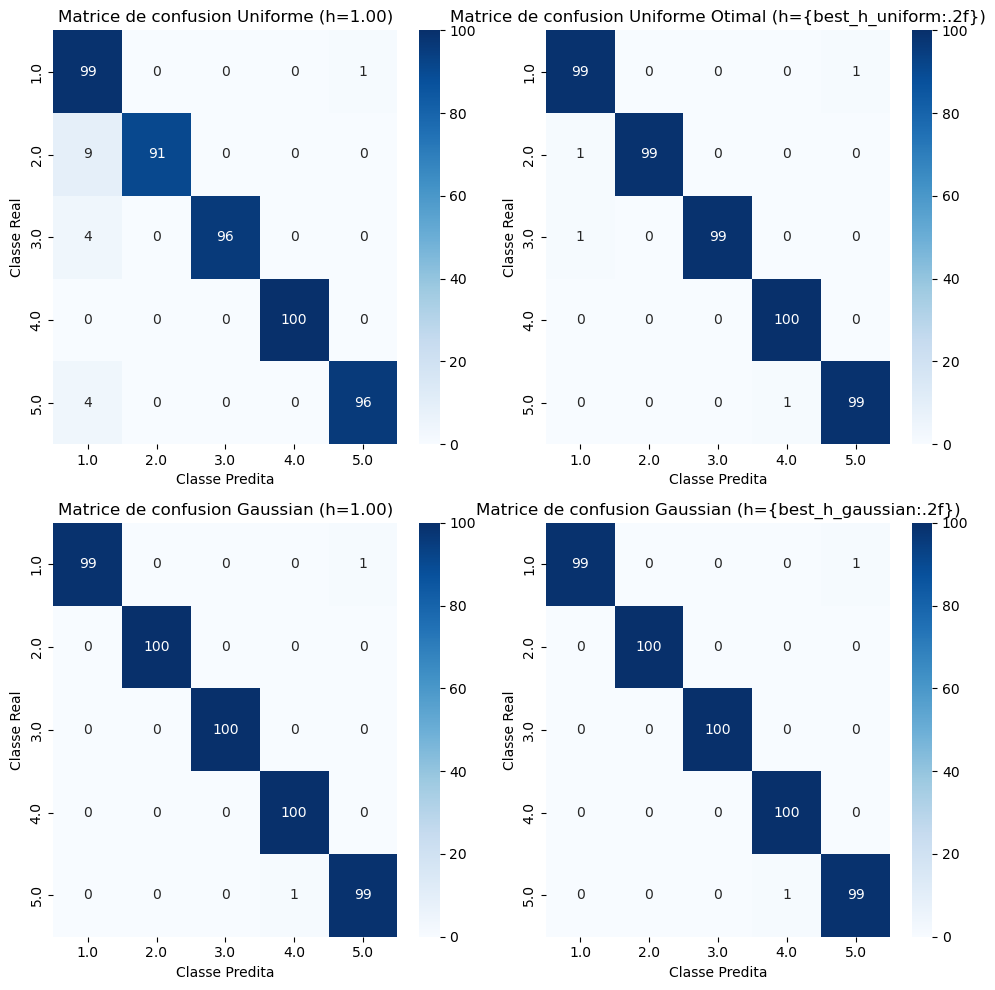

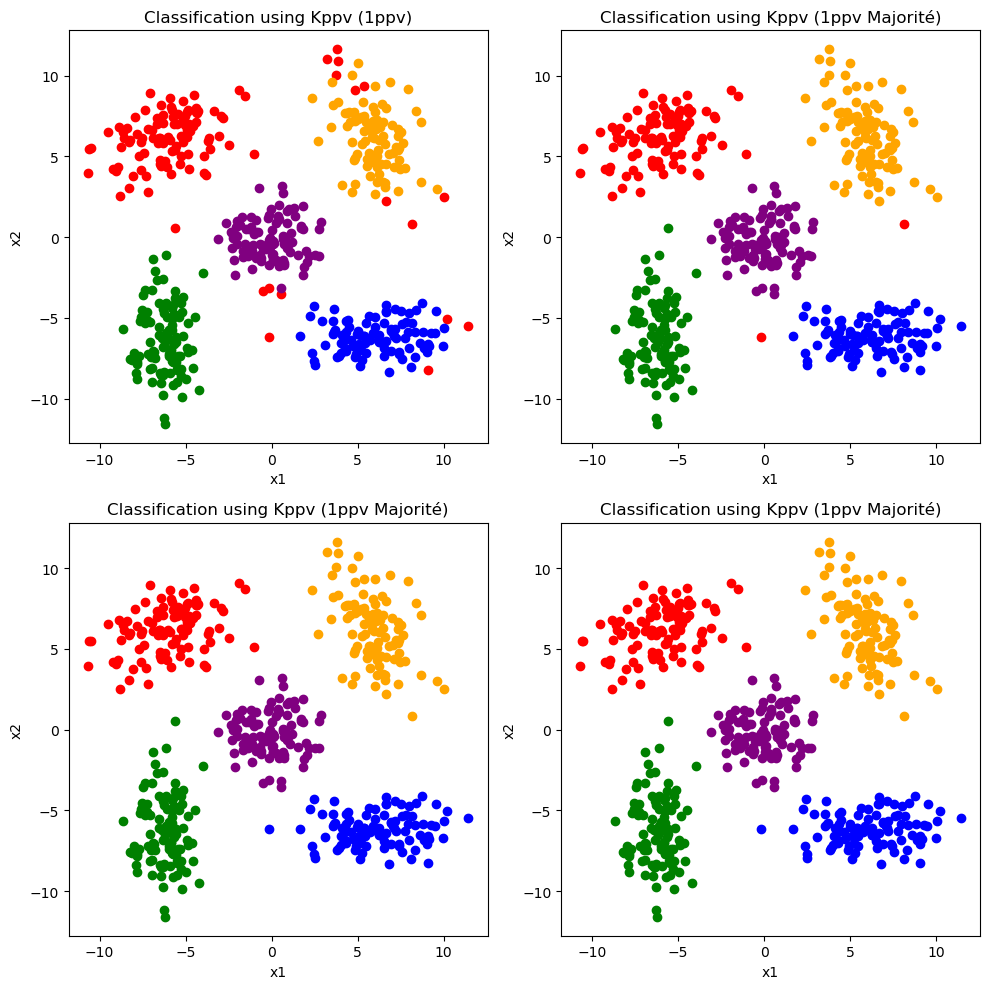

In [16]:
PredictResults_Parzen(X_train1, y_train1, X_test1, y_test1, 1.0)


## Séparation linéaire

In [19]:
class Perceptron:
    def __init__(self, learning_rate=0.1, max_iter=1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Treina o perceptron usando o conjunto de dados X, y.
        """
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.max_iter):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = np.sign(linear_output)
                if y[idx] * y_predicted <= 0:
                    # Atualização da regra do perceptron
                    self.weights += self.learning_rate * y[idx] * x_i
                    self.bias += self.learning_rate * y[idx]

    def predict(self, X):
        """
        Realiza predições para o conjunto de dados X.
        """
        linear_output = np.dot(X, self.weights) + self.bias
        return np.sign(linear_output)


In [23]:

def train_perceptron_ovr(X_train, y_train):
    """
    Treina perceptrons para cada combinação de classes usando a estratégia One-vs-One.
    Retorna os classificadores e os pares de classes correspondentes.
    """
    classifiers = {}
    class_pairs = list(combinations(np.unique(y_train), 2))

    for class1, class2 in class_pairs:
        # Filtrar dados para as duas classes
        X_subset = X_train[(y_train == class1) | (y_train == class2)]
        y_subset = y_train[(y_train == class1) | (y_train == class2)]
        
        # Transformar rótulos: class1 -> +1, class2 -> -1
        y_subset = np.where(y_subset == class1, 1, -1)

        # Treinar o perceptron
        perceptron = Perceptron(learning_rate=0.01, max_iter=1000)
        perceptron.fit(X_subset, y_subset)
        
        # Salvar o classificador
        classifiers[(class1, class2)] = perceptron

    return classifiers

def predict_ovr(X_test, y_train, classifiers):
    """
    Faz predições usando os classificadores treinados na estratégia One-vs-One.
    """
    votes = np.zeros((X_test.shape[0], len(classifiers)))

    # Votação de cada par de classes
    for idx, ((class1, class2), perceptron) in enumerate(classifiers.items()):
        predictions = perceptron.predict(X_test)
        for i, pred in enumerate(predictions):
            if pred == 1:
                votes[i, idx] = class1
            else:
                votes[i, idx] = class2

    # Classe final com mais votos
    final_predictions = [np.bincount(row.astype(int)).argmax() for row in votes]
    prediction = np.array(final_predictions)
    
    unique_classes = np.unique(y_train)
    point_colors = ['red', 'orange', 'blue', 'green', 'purple', 'gray']
    
    for i in unique_classes:
        plt.scatter(X_test[prediction == i, 0], X_test[prediction == i, 1], c=point_colors[int(i) - 1])
    plt.title("Classification using Kppv (1ppv Majorité)")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()
    
    return np.array(final_predictions)



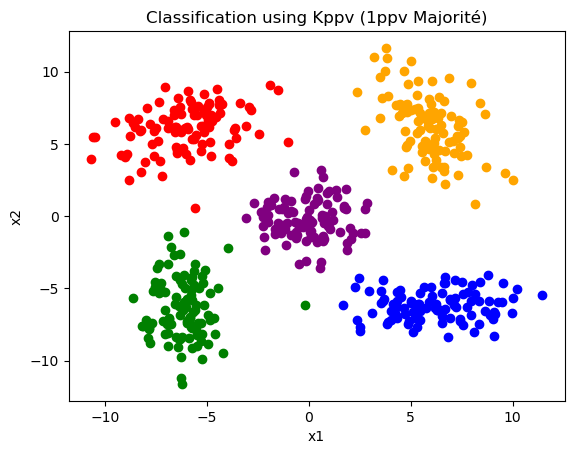

Acurácia: 99.40%


In [24]:
classifiers = train_perceptron_ovr(X_train1, y_train1)
y_pred = predict_ovr(X_test1, y_train1, classifiers)

# Avaliação
accuracy = accuracy_score(y_test1, y_pred)
print(f"Acurácia: {accuracy * 100:.2f}%")